In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import sklearn
from sklearn import svm
from sklearn import model_selection
from sklearn.metrics import recall_score,precision_score
from statsmodels.tsa.arima_model import ARIMA 

preocess：数据预处理函数

In [5]:
def process(filename,sheetname):
    data=pd.read_excel(filename,sheet_name=sheetname)
    data.columns=['企业代号','发票号码','开票日期','单位代号','金额','税额','价税合计','发票状态']
    if data.loc[1,'企业代号']!=1:
        data['企业代号']=data['企业代号']-123#企业代号为了方便，转化为数字
    invalidindex=[]
    n=data['企业代号'].max()+1
    print(n)
    invalid=[0]*n
    for i in range(len(data)):
        if data.loc[i,'发票状态']=='作废发票':
            invalidindex.append(i)#记录作废发票在记录之中的下标，将相应的记录去掉
    data=data.drop(index=invalidindex)
    data.index=list(range(len(data)))
    group=data.groupby('企业代号')
    
    minus=[0]*n
    minus_index=[]
    depart_index=[]
    for i in range(len(data)):
        if data.loc[i,'价税合计']<0:
            minus[data.loc[i,'企业代号']]+=data.loc[i,'价税合计']
            minus_index.append(i)# 记录负数发票的下标
    minus_ratio=[0]*n
    for i in range(1,n):
        minus_ratio[i]=abs(minus[i])/group.get_group(i)['价税合计'].sum()# 计算负数发票的比重
    return data,minus_ratio

数据预处理

In [5]:
buy,buy_minus_ratio=process('E:\\2020CUMCM\\CUMCM2020Probelms\\C\\data1.xlsx','进项发票信息')
sell,sell_minus_ratio=process('E:\\2020CUMCM\\CUMCM2020Probelms\\C\\data1.xlsx','销项发票信息')

124
124


计算每一个月的净值中位数

In [139]:
buy['tag']=-1*buy['价税合计']#调整符号
sell['tag']=sell['价税合计']
sq_month=[[0]]#每一个元素都是一家企业的月净值信息
for j in range(1,124):
    sq_month.append([0])
    flow=pd.concat([buy[buy['企业代号']==j],sell[sell['企业代号']==j]],axis=0)#整合销方发票和买方发票信息
    flow=flow.sort_values(by=['开票日期'],ascending=True)#按照日期前后进行排序
    flow['开票日期']=pd.to_datetime(flow['开票日期'])
    begin = flow['开票日期'].min()
    end = flow['开票日期'].max()
    lastmonth=0
    agg=0
    change=[0]
    for i in range((end - begin).days + 1):
        day = begin + datetime.timedelta(days=i)
        if (day.__getattribute__('month')!=lastmonth) and i:#进入一个新的月份
            sq_month[j].append(np.median(change)+agg)
            agg+=change[-1]
            lastmonth=day.__getattribute__('month')
            change=[0]
            change.append(flow.loc[flow['开票日期']==day,'tag'].sum())
        else:
            if day in list(flow['开票日期']):#当日有交易
                change.append(change[-1]+flow.loc[flow['开票日期']==day,'tag'].sum())#记录当日交易给净值带来的变化
            else:
                change.append(change[-1])
    sq_month[j].append(np.median(change)+agg)

存储月净值

In [141]:
store=pd.DataFrame(sq_month).T
wb=Workbook()
ws=wb.active
ws.append(list(range(124)))
for i in range(len(store)):
    line=list(store.loc[i])
    ws.append(line)
wb.save('sq_month.xlsx')

记录每一家企业交易记录所在的月份

In [122]:
month=[[0]]
for j in range(1,124):
    month.append([0])
    flow=pd.concat([buy[buy['企业代号']==j],sell[sell['企业代号']==j]],axis=0)#整合销方发票和买方发票信息
    flow=flow.sort_values(by=['开票日期'],ascending=True)#按照日期前后进行排序
    flow['开票日期']=pd.to_datetime(flow['开票日期'])
    begin = flow['开票日期'].min()
    end = flow['开票日期'].max()
    lastmonth=0
    agg=0
    change=[0]
    for i in range((end - begin).days + 1):
        day = begin + datetime.timedelta(days=i)
        if day.__getattribute__('month')!=lastmonth:#进入一个新月份
            month[j].append(str(day.__getattribute__('year'))+'-'+str(day.__getattribute__('month')))#记录新月份
            lastmonth=day.__getattribute__('month')
    month[j].append(str(day.__getattribute__('year'))+'-'+str(day.__getattribute__('month')))

存储月份信息

In [124]:
store=pd.DataFrame(month).T
wb=Workbook()
ws=wb.active
ws.append(list(range(124)))
for i in range(len(store)):
    line=list(store.loc[i])
    ws.append(line)
wb.save('month.xlsx')

计算峰度和偏度并存储

In [170]:
kurtlist=[0]
for i in range(1,124):
    part_sell=sell.loc[sell['企业代号']==i]
    group=part_sell.groupby('单位代号')##按照买方单位代号进行分组
    kurtlist.append(group['价税合计'].sum().kurt())

In [246]:
skewlist=[0]
for i in range(1,124):
    part_buy=buy.loc[buy['企业代号']==i]
    skewlist.append(part_buy['价税合计'].skew())

In [245]:
wb=Workbook()
ws=wb.active
ws.append(['skew','kurt'])
for i in range(1,124):
    line=[skewlist[i],kurtlist[i]]
    ws.append(line)
wb.save('峰度偏度.xlsx')

arima：使用ARIMA进行时间序列分析的函数

In [17]:
def arima(sample,dx):
    pmax = int(len(dx) / 10)    #一般阶数不超过 length /10
    qmax = int(len(dx) / 10)
    bic_matrix = []
    for p in range(pmax +1):
        temp= []
        for q in range(qmax+1):
            try:
                temp.append(ARIMA(sample, (p, 1, q)).fit().bic)
            except:
                temp.append(None)
            bic_matrix.append(temp)

    bic_matrix = pd.DataFrame(bic_matrix)   
    p,q = bic_matrix.stack().idxmin()  #找出最小值所在位置
    model = ARIMA(sample, (p,1,q)).fit()#模型拟合
    return list(model.forecast(6)[0])

预测123家企业在未来6个月之中的净值

In [118]:
pred=[[0,0,0,0,0,0]]
for i in range(1,124):
    sample=pd.DataFrame(sq_month.loc[i].dropna())
    dx=sample.diff().dropna()
    sample.columns=['value']
    try:
        one=arima(sample,dx)
    except:
        one=[0,0,0,0,0,0]
    pred.append(one)

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\li

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\li

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-pack

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\A

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\A

计算六个月净值预测值的中位数和变异系数并进行存储

In [39]:
pred['median']=''
pred['cv']=''
for i in range(123):
    line=pred.loc[i,['pred1','pred2','pred3','pred4','pred5','pred6']]
    pred.loc[i,'median']=line.median()
    pred.loc[i,'cv']=np.std(line)/line.mean()
    #pred.loc[i,'minus']=sell_minus_ratio[i+1]

In [43]:
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
ws.append(['pred1','pred2','pred3','pred4','pred5','pred6','median','cv'])
for i in range(123):
    line=list(pred.loc[i])
    ws.append(line)
wb.save('pred.xlsx')

整合SVM模型训练所需要的全部因子，并将因子进行存储

In [46]:
pred=pd.read_excel('pred.xlsx')
month_loss=(pd.read_excel('month_loss.xlsx')).T
svmdata=pred.drop(columns=['pred1','pred2','pred3','pred4','pred5','pred6'])
svmdata['minus']=''
svmdata['loss']=''
svmdata['skew']=''
svmdata['kurt']=''
#svmdata['flow']=''
svmdata['rank']=''
for i in range(123):
    svmdata.loc[i,'minus']=sell_minus_ratio[i+1]
    svmdata.loc[i,'loss']=np.max(month_loss.loc[i+1])
    #svmdata.loc[i,'flow']=sell.loc[sell['企业代号']==i+1,'价税合计'].sum()+buy.loc[buy['企业代号']==i+1,'价税合计'].sum()
sk=pd.read_excel('峰度偏度.xlsx')
svmdata['skew']=sk['skew']
svmdata['kurt']=sk['kurt']
svmdata['rank']=sk['评级']

In [47]:
svmdata

,median,cv,minus,loss,skew,kurt,rank
0,-2.634448e+09,-0.048108,0.0447572,0,1.499110,79.178842,A
1,5.257282e+08,0.047761,0.0353747,4.7529e+08,16.060945,145.074478,A
2,8.613177e+08,0.046245,0.0330502,7.90716e+08,7.752323,42.995063,C
3,2.054814e+09,0.048489,0.00204402,1.8953e+09,4.413750,22.859660,C
4,5.886720e+06,0.045550,0,4.48609e+06,12.793923,19.818435,B
...,...,...,...,...,...,...,...
118,-2.268027e+05,-0.046790,0,0,5.951263,4.804168,D
119,1.985560e+05,0.052548,0,177173,5.770543,-1.843264,D
120,-1.169477e+06,-0.020424,0.0318995,0,0.470291,79.781121,D
121,7.281747e+03,0.044359,0.0655719,24568.1,5.227372,12.324407,D


In [669]:
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
ws.append(['median','cv','minus','loss','skew','kurt','rank'])
for i in range(len(svmdata)):
    ws.append(list(svmdata.loc[i]))
wb.save('factor1.xlsx')

要素预处理

In [329]:
import sklearn
from sklearn import svm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score
x,y=np.split(svmdata,indices_or_sections=(6,),axis=1) #x为数据，y为标签
x['skew']=x['skew'].fillna(0)
x['kurt']=x['kurt'].fillna(0)#峰度和偏度的缺失值全部填充为0
x['cv']=np.abs(x['cv'])
x['cv']=(x['cv']-np.min(x['cv']))/(np.max(x['cv'])-np.min(x['cv']))
#x['flow']=(x['flow']-np.min(x['flow']))/(np.max(x['flow'])-np.min(x['flow']))
#x=x.drop(columns=['cv'])
x['median']=(x['median']-np.min(x['median']))/(np.max(x['median'])-np.min(x['median']))#数据归一化操作
#x=x.drop(columns=['median'])
x['loss']=(x['loss']-np.min(x['loss']))/(np.max(x['loss'])-np.min(x['loss']))
x=x.drop(columns=['loss'])
x['minus']=(x['minus']-np.min(x['minus']))/(np.max(x['minus'])-np.min(x['minus']))
#x=x.drop(columns=['minus'])
x['skew']=(x['skew']-np.min(x['skew']))/(np.max(x['skew'])-np.min(x['skew']))
#x=x.drop(columns=['skew'])
x['kurt']=(x['kurt']-np.min(x['kurt']))/(np.max(x['kurt'])-np.min(x['kurt']))
#分割训练集和测试集
train_data,test_data,train_label,test_label =sklearn.model_selection.train_test_split(x,y, random_state=1, train_size=0.7,test_size=0.3)

In [330]:
x

,median,cv,minus,skew,kurt
0,0,0.0141002,0.145083,0.062529,0.024367
1,0.673918,0.0139238,0.114669,0.344326,0.043657
2,0.745483,0.0131513,0.107134,0.183539,0.013774
3,1,0.0142941,0.0066258,0.118932,0.007880
4,0.56306,0.0127975,0,0.281103,0.006990
...,...,...,...,...,...
118,0.561756,0.0134289,0,0.148686,0.002595
119,0.561847,0.016362,0,0.145188,0.000649
120,0.561555,0,0.103404,0.042619,0.024543
121,0.561806,0.0121909,0.212555,0.134677,0.004796


SVM 尝试

In [331]:
classifier=svm.SVC(C=2,kernel='rbf') 
classifier.fit(train_data,train_label) #SVM拟合
pred_label=classifier.predict(test_data)#SVM预测
print(recall_score(test_label,pred_label,average='micro'))
print(precision_score(test_label,pred_label,average='micro'))
pred_label

0.2972972972972973
0.2972972972972973


C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array(['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
      dtype=object)

决策树尝试

In [332]:
clf=DecisionTreeClassifier(max_depth = 4,random_state = 2)
clf.fit(train_data,train_label)
pred_label=clf.predict(test_data)
print(accuracy_score(test_label,pred_label))
print(recall_score(test_label,pred_label,average='micro'))
print(precision_score(test_label,pred_label,average='micro'))
pred_label
#final_clf=clf

0.35135135135135137
0.35135135135135137
0.35135135135135137


array(['C', 'D', 'B', 'A', 'C', 'B', 'B', 'C', 'B', 'B', 'C', 'A', 'D',
       'C', 'A', 'A', 'A', 'C', 'C', 'B', 'C', 'C', 'A', 'A', 'D', 'B',
       'C', 'C', 'D', 'C', 'C', 'B', 'C', 'D', 'C', 'A', 'C'],
      dtype=object)

Adaboost尝试

In [389]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=250, learning_rate=0.20)#设置Adaboost分类器
bdt.fit(train_data, train_label)
pred_label=bdt.predict(test_data)
print(accuracy_score(test_label,pred_label))
print(recall_score(test_label,pred_label,average='micro'))
print(precision_score(test_label,pred_label,average='micro'))
print(metrics.confusion_matrix(test_label, pred_label, sample_weight=None))#打印混淆矩阵
pred_label
#final_clf=bdt

C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2702702702702703
0.2702702702702703
0.2702702702702703
[[3 1 0 1]
 [2 3 3 3]
 [3 5 2 1]
 [1 1 6 2]]


PCA 处理

In [149]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
trim= pca.fit(x).transform(x)
print(x.shape)#原始变量维度
print(trim.shape)#主成分变量的维度
trim=pd.DataFrame(trim)
print('各主成分贡献度:{}'.format(pca.explained_variance_ratio_))
train_data,test_data,train_label,test_label =sklearn.model_selection.train_test_split(trim,y,random_state=1, train_size=0.7,test_size=0.3)

(123, 4)
(123, 4)
各主成分贡献度:[0.38423634 0.27491603 0.24362806 0.09721958]


SVM 尝试（PCA）

In [150]:
svmclf=svm.SVC(C=2,kernel='rbf') 
svmclf.fit(train_data,train_label) #ravel函数在降维时默认是行序优先
pred_label=svmclf.predict(test_data)
print(recall_score(test_label,pred_label,average='micro'))
print(precision_score(test_label,pred_label,average='micro'))

0.2972972972972973
0.2972972972972973


C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


决策树（PCA）

In [390]:

treeclf=DecisionTreeClassifier(max_depth = 6,random_state = 2)
treeclf.fit(train_data,train_label)
pred_label=treeclf.predict(test_data)
print(accuracy_score(test_label,pred_label))
print(recall_score(test_label,pred_label,average='macro'))
print(precision_score(test_label,pred_label,average='macro'))
#final_clf=treeclf

0.2702702702702703
0.2590909090909091
0.3187441643323996


Adaboost(PCA)

In [465]:
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=11, min_samples_split=5, min_samples_leaf=10),
                         algorithm="SAMME",
                         n_estimators=150, learning_rate=0.25)
bdt.fit(train_data, train_label)
pred_label=bdt.predict(test_data)
print(accuracy_score(test_label,pred_label))
print(recall_score(test_label,pred_label,average='micro'))
print(precision_score(test_label,pred_label,average='micro'))
final_clf=bdt

0.35135135135135137
0.35135135135135137
0.35135135135135137


C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


第二问

导入数据并进行预处理

In [6]:
buy,buy_minus_ratio=process('E:\\2020CUMCM\\CUMCM2020Probelms\\C\\data2.xlsx','进项发票信息')
sell,sell_minus_ratio=process('E:\\2020CUMCM\\CUMCM2020Probelms\\C\\data2.xlsx','销项发票信息')

303
303


计算302家企业每一个月的净值并存储

In [14]:
import datetime
buy['tag']=-1*buy['价税合计']
sell['tag']=sell['价税合计']
sq_month=[[0]]
for j in range(1,303):
    sq_month.append([0])
    flow=pd.concat([buy[buy['企业代号']==j],sell[sell['企业代号']==j]],axis=0)# 将销方发票和买方发票进行整合
    flow=flow.sort_values(by=['开票日期'],ascending=True)#按照日期进行排序
    flow['开票日期']=pd.to_datetime(flow['开票日期'])
    begin = flow['开票日期'].min()
    end = flow['开票日期'].max()
    lastmonth=0
    agg=0
    change=[0]
    for i in range((end - begin).days + 1):
        day = begin + datetime.timedelta(days=i)
        if (day.__getattribute__('month')!=lastmonth) and i:#进入一个新的月份
            sq_month[j].append(np.median(change)+agg)
            agg+=change[-1]
            lastmonth=day.__getattribute__('month')
            change=[0]
            change.append(flow.loc[flow['开票日期']==day,'tag'].sum())
        else:
            if day in list(flow['开票日期']):#当日有交易记录
                change.append(change[-1]+flow.loc[flow['开票日期']==day,'tag'].sum())
            else:
                change.append(change[-1])
    sq_month[j].append(np.median(change)+agg)

In [16]:
store=pd.DataFrame(sq_month).T
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
ws.append(list(range(0,303)))
for i in range(len(store)):
    ws.append(list(store.loc[i]))
wb.save('sq_month2.xlsx')

使用ARIMA预测未来六个月的公司净值

In [21]:
from statsmodels.tsa.arima_model import ARIMA 
pred=[[0,0,0,0,0,0]]
for i in range(1,303):
    sample=pd.DataFrame(sq_month[i]).dropna()
    dx=sample.diff().dropna()
    sample.columns=['value']
    try:
        one=arima(sample,dx)
    except:
        one=[0,0,0,0,0,0]
    pred.append(one)

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\stat

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-pack

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-pack

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\li

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\bas

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\A

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-pack

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\li

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\A

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\A

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\li

C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\LQ\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\LQ\A

In [24]:
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
ws.append(['pred1','pred2','pred3','pred4','pred5','pred6'])
for i in range(len(pred)):
    ws.append(list(pred[i]))
wb.save('pred2.xlsx')

计算信用评级的影响因子

In [334]:
pred=pd.read_excel('pred2.xlsx')
factor=pred
factor['median']=''
factor['cv']=''
factor['minus']=''
factor['skew']=''
factor['kurt']=''
for i in range(1,303):
    line=pred.loc[i,['pred1','pred2','pred3','pred4','pred5','pred6']]
    #line.columns=['value']
    factor.loc[i,'median']=line.median()
    factor.loc[i,'cv']=np.std(line)/line.mean()
    factor.loc[i,'skew']=buy.loc[buy['企业代号']==i,'价税合计'].skew()
    part_sell=sell.loc[sell['企业代号']==i]
    group=part_sell.groupby('单位代号')
    factor.loc[i,'kurt']=group['价税合计'].sum().kurt()
    factor.loc[i,'minus']=sell_minus_ratio[i]
factor['skew']=factor['skew'].fillna(0)
factor['kurt']=factor['kurt'].fillna(0)#缺失值填充
factor=factor.drop(index=[0])#第一列是为了补齐下标而填充的，应当去掉
factor.index=list(range(len(factor)))
factor=factor.drop(columns=['pred1','pred2','pred3','pred4','pred5','pred6'])

In [335]:
#进行数据归一化处理
factor['median']=(factor['median']-np.min(factor['median']))/(np.max(factor['median'])-np.min(factor['median']))
factor['cv']=(factor['cv']-np.min(factor['cv']))/(np.max(factor['cv'])-np.min(factor['cv']))
factor['skew']=(factor['skew']-np.min(factor['skew']))/(np.max(factor['skew'])-np.min(factor['skew']))
factor['kurt']=(factor['kurt']-np.min(factor['kurt']))/(np.max(factor['kurt'])-np.min(factor['kurt']))#归一化
factor['minus']=(factor['minus']-np.min(factor['minus']))/(np.max(factor['minus'])-np.min(factor['minus']))

In [336]:
factor

,median,cv,minus,skew,kurt
0,0.107788,0.204607,0.145083,0.410733,0.00720287
1,0.158775,0.237984,0.114669,0.39322,0.0101407
2,0.642534,0.237984,0.107134,0.131138,0.0249725
3,1,0.237984,0.0066258,0.679628,0.00445136
4,0.434456,0.237984,0,0.329486,0.00645582
...,...,...,...,...,...
297,0.116052,0.23911,0,0.10642,0.00481517
298,0.115793,0.24717,0,0.12604,0.00880418
299,0.115758,0.239526,0,0.090086,0.00291889
300,0.115494,0.20524,0.0511707,0.151265,0.0133572


使用最好的分类器对数据进行拟合并保存

In [466]:
final_clf.fit(x,y)
#factor=factor.drop(columns=['minus'])
rating=final_clf.predict(factor.iloc[:,[0,1,2,3,4]])
factor['rank']=''
factor['rank']=pd.DataFrame(rating)
factor

C:\Users\LQ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,median,cv,minus,skew,kurt,rank
0,0.107788,0.204607,0.145083,0.410733,0.00720287,B
1,0.158775,0.237984,0.114669,0.39322,0.0101407,B
2,0.642534,0.237984,0.107134,0.131138,0.0249725,A
3,1,0.237984,0.0066258,0.679628,0.00445136,C
4,0.434456,0.237984,0,0.329486,0.00645582,B
...,...,...,...,...,...,...
297,0.116052,0.23911,0,0.10642,0.00481517,D
298,0.115793,0.24717,0,0.12604,0.00880418,D
299,0.115758,0.239526,0,0.090086,0.00291889,D
300,0.115494,0.20524,0.0511707,0.151265,0.0133572,D


In [468]:
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
ws.append(['median','cv','skew','kurt','minus','rank'])
for i in range(len(factor)):
    ws.append(list(factor.loc[i]))
wb.save('factor2.xlsx')

企业类别分类，并将结果保存

In [483]:
#从附表二之中读取数据
enterprise=pd.read_excel('E:\\2020CUMCM\\CUMCM2020Probelms\\C\\data2.xlsx',sheet_name='企业信息')


In [502]:
#跟据企业名字之中的关键字来分类企业
enterprise['类别']=''
for i in range(len(enterprise)):
    if str(enterprise.loc[i,'企业名称']).find('个体')!=-1:
        enterprise.loc[i,'类别']='个体'
    elif (str(enterprise.loc[i,'企业名称']).find('工程')!=-1) or (str(enterprise.loc[i,'企业名称']).find('建筑')!=-1):
        enterprise.loc[i,'类别']='建筑'
    elif (str(enterprise.loc[i,'企业名称']).find('园林')!=-1) or (str(enterprise.loc[i,'企业名称']).find('园艺')!=-1):
        enterprise.loc[i,'类别']='园林'
    elif str(enterprise.loc[i,'企业名称']).find('食品')!=-1:
        enterprise.loc[i,'类别']='饮食'
    elif str(enterprise.loc[i,'企业名称']).find('劳务')!=-1:
        enterprise.loc[i,'类别']='劳务'
    elif str(enterprise.loc[i,'企业名称']).find('食')!=-1:
        enterprise.loc[i,'类别']='饮食'
    elif str(enterprise.loc[i,'企业名称']).find('材')!=-1:
        enterprise.loc[i,'类别']='材料'
    elif str(enterprise.loc[i,'企业名称']).find('电')!=-1:
        enterprise.loc[i,'类别']='电子'
    elif str(enterprise.loc[i,'企业名称']).find('贸')!=-1:
        enterprise.loc[i,'类别']='商贸'
    elif str(enterprise.loc[i,'企业名称']).find('机械')!=-1:
        enterprise.loc[i,'类别']='机械'
    elif (str(enterprise.loc[i,'企业名称']).find('医')!=-1) or (str(enterprise.loc[i,'企业名称']).find('药')!=-1):
        enterprise.loc[i,'类别']='医疗'
    elif str(enterprise.loc[i,'企业名称']).find('运')!=-1:
        enterprise.loc[i,'类别']='运输'
    elif str(enterprise.loc[i,'企业名称']).find('物流')!=-1:
        enterprise.loc[i,'类别']='物流'
    elif str(enterprise.loc[i,'企业名称']).find('设备')!=-1:
        enterprise.loc[i,'类别']='设备'
    elif str(enterprise.loc[i,'企业名称']).find('体育')!=-1:
        enterprise.loc[i,'类别']='体育'
    elif (str(enterprise.loc[i,'企业名称']).find('环')!=-1) or (str(enterprise.loc[i,'企业名称']).find('生态')!=-1):
        enterprise.loc[i,'类别']='环保'
    elif str(enterprise.loc[i,'企业名称']).find('科技')!=-1:
        enterprise.loc[i,'类别']='科技'
    elif (str(enterprise.loc[i,'企业名称']).find('文化')!=-1) or (str(enterprise.loc[i,'企业名称']).find('影')!=-1):
        enterprise.loc[i,'类别']='文娱'
    elif str(enterprise.loc[i,'企业名称']).find('律师')!=-1:
        enterprise.loc[i,'类别']='法律'

In [501]:
from openpyxl import Workbook
wb=Workbook()
ws=wb.active
for i in range(len(enterprise)):
    ws.append([enterprise.loc[i,'类别']])
wb.save('temp.xlsx')

In [94]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic
k1=pd.read_excel('k1.xls')
k2=pd.read_excel('k2.xls')
k3=pd.read_excel('k3.xls')
k1=k1.drop(columns=['证券代码','证券名称','交易时间','开盘价','最高价','最低价','涨跌','涨跌幅%','成交量','成交额'])
k2=k2.drop(columns=['证券代码','证券名称','交易时间','开盘价','最高价','最低价','涨跌','涨跌幅%','成交量','成交额'])
k3=k3.drop(columns=['证券代码','证券名称','交易时间','开盘价','最高价','最低价','涨跌','涨跌幅%','成交量','成交额'])
k1=pd.DataFrame(k1['收盘价'].dropna())
k2=pd.DataFrame(k2['收盘价'].dropna())
k3=pd.DataFrame(k3['收盘价'].dropna())
k1=k1.drop(index=list(range(1405,len(k1))))
k3=k3.drop(index=list(range(1405,len(k3))))
k1.columns=['price1']
k2.columns=['price2']
k3.columns=['price3']

In [95]:
k3['price']=k3['price3']*0.7

In [96]:
k12=pd.concat([k1,k2],axis=1)
k13=pd.concat([k1,k3],axis=1)
k23=pd.concat([k2,k3],axis=1)

In [97]:
#建立对象，dataframe就是前面的data，varLagNum就是你自己定的滞后阶数
varLagNum=2
orgMod = sm.tsa.VARMAX(k13,order=(varLagNum,0),trend='nc',exog=None)
#估计：就是模型
fitMod = orgMod.fit(maxiter=1000,disp=False)
# 打印统计结果
print(fitMod.summary())
# 获得模型残差
resid = fitMod.resid
result = {'fitMod':fitMod,'resid':resid}

LinAlgError: Matrix is not positive definite

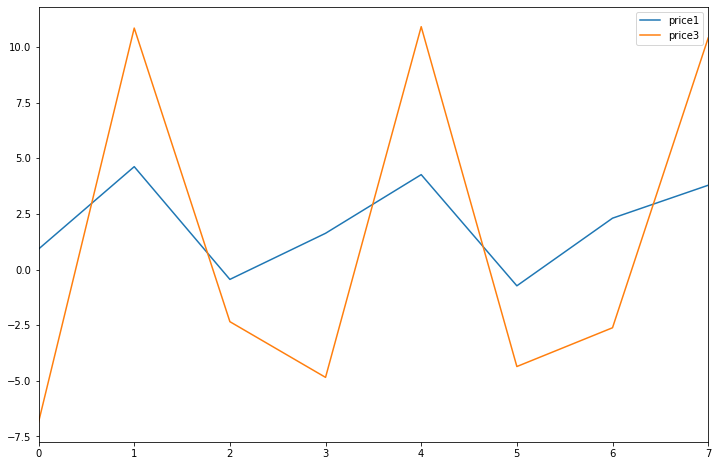

In [83]:
import matplotlib.pyplot as plt
terms=7
# orthogonalized=True，代表采用乔里斯基正交 
ax = fitMod.impulse_responses(terms, orthogonalized=True).plot(figsize=(12, 8))
plt.show()

<BarContainer object of 10 artists>

C:\Users\LQ\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LQ\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LQ\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LQ\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33647 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LQ\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LQ\AppData\Roaming\Python\Python37\site-p

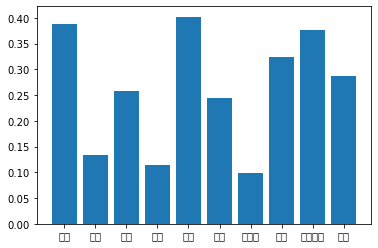

In [102]:
import matplotlib.pyplot as plt
name=['个体','医药','材料','科技','餐饮','电子','互联网','建筑','零售商贸','运输']
depth=[0.3879,0.1336,0.2579,0.1142,0.4022,0.2438,0.0981,0.3246,0.3765,0.2871]
plt.bar(name,depth)
